# IMPORTATION DES PACKAGES

In [1]:
import pandas as pd
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
import warnings
warnings.filterwarnings("ignore")

# Description et visualisation du jeu de données

In [2]:
# les fonctions definitives pour eviter de faire cellule par cellule
def description(file):
    data = pd.read_csv(file)
    print("le jeu de données contient ",data.shape[0]," lignes et ", data.shape[1]," colonnes\n")
    print("les 10 premières du jeu de données :\n")
    print(data.head())
    print("les différents types de données:\n")
    print(data.dtypes)
    print("la description des données de type numériques:\n")
    print(data.describe())
    print("la distribution des observations en fonction de la variable cible:\n")
    round(data["Result"].value_counts(normalize=True),2)
    
    return(data)
    

def visualisation (data, Y, title):
    # print("la distribution des observations en fonction de la variable cible:\n")
    round(data["Result"].value_counts(normalize=True),2)
    sns.countplot(x=Y, data=data)
    plt.xlabel('Les 2 types de résultats')
    plt.ylabel('Nombre d\'occurrences')
    plt.title(title)
    plt.show()
    
    data.dtypes.value_counts().plot.pie()
    plt.show()
    
    sns.scatterplot(data=data, x="Systolic blood pressure", y="Age", hue=data["Result"])
    plt.title("Scatter plot of systolic pressure by age")
    plt.show()
    
    sns.pairplot(data)
    plt.show()
    for col in data.select_dtypes(['int','float']):
        plt.figure
        sns.boxplot(data[col])
        plt.title(col)
        plt.show()
    
def split(data,size,class_label):
    train_set, test_set = train_test_split(data, train_size=size, random_state=0, stratify=class_label)
    return train_set, test_set


def split_2(train_set, test_set):
    y_test = test_set["Result"]
    y_train = train_set["Result"]
    # encoder = preprocessing.LabelEncoder()
    # Y_encd = encoder.fit_transform(Y)
    x_train = train_set.iloc[:, [0, 1, 2, 3]]
    x_test = test_set.iloc[:, [0, 1, 2, 3]]
    return x_train, x_test, y_train, y_test


def preprocess(data):
    data_clean = data.copy()
    for col in data_clean.select_dtypes(['int','float']).columns:
        Q1 = data_clean[col].quantile(0.25)
        Q3 = data_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        # print(IQR, Q1-1.5*IQR, Q3+1.5*IQR)
        data_clean = data_clean[~((data_clean[col]<(Q1-1.5*IQR))|(data_clean[col]>(Q3+1.5*IQR)))]
    return(data_clean)

# def encodage():
    

le jeu de données contient  1319  lignes et  9  colonnes

les 10 premières du jeu de données :

   Age  Gender  Heart rate  Systolic blood pressure  Diastolic blood pressure  \
0   64       1          66                      160                        83   
1   21       1          94                       98                        46   
2   55       1          64                      160                        77   
3   64       1          70                      120                        55   
4   55       1          64                      112                        65   

   Blood sugar  CK-MB  Troponin    Result  
0        160.0   1.80     0.012  negative  
1        296.0   6.75     1.060  positive  
2        270.0   1.99     0.003  negative  
3        270.0  13.87     0.122  positive  
4        300.0   1.08     0.003  negative  
les différents types de données:

Age                           int64
Gender                        int64
Heart rate                    int64
Systolic bl

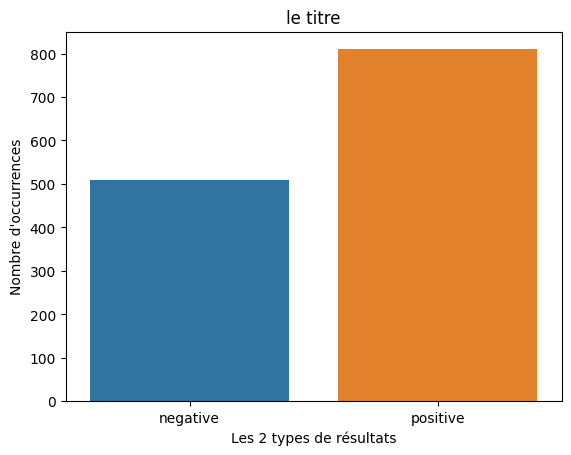

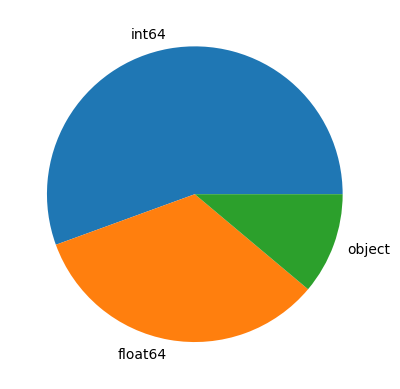

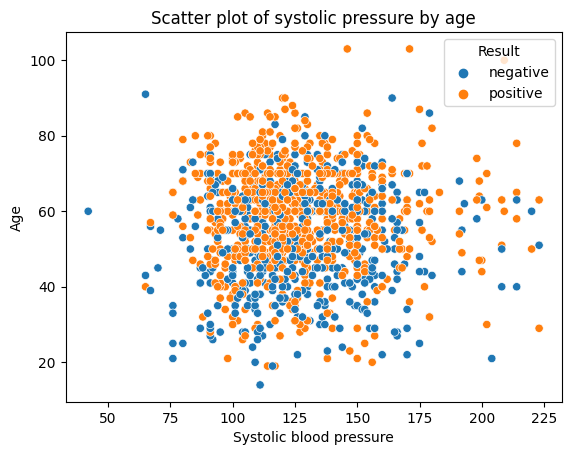

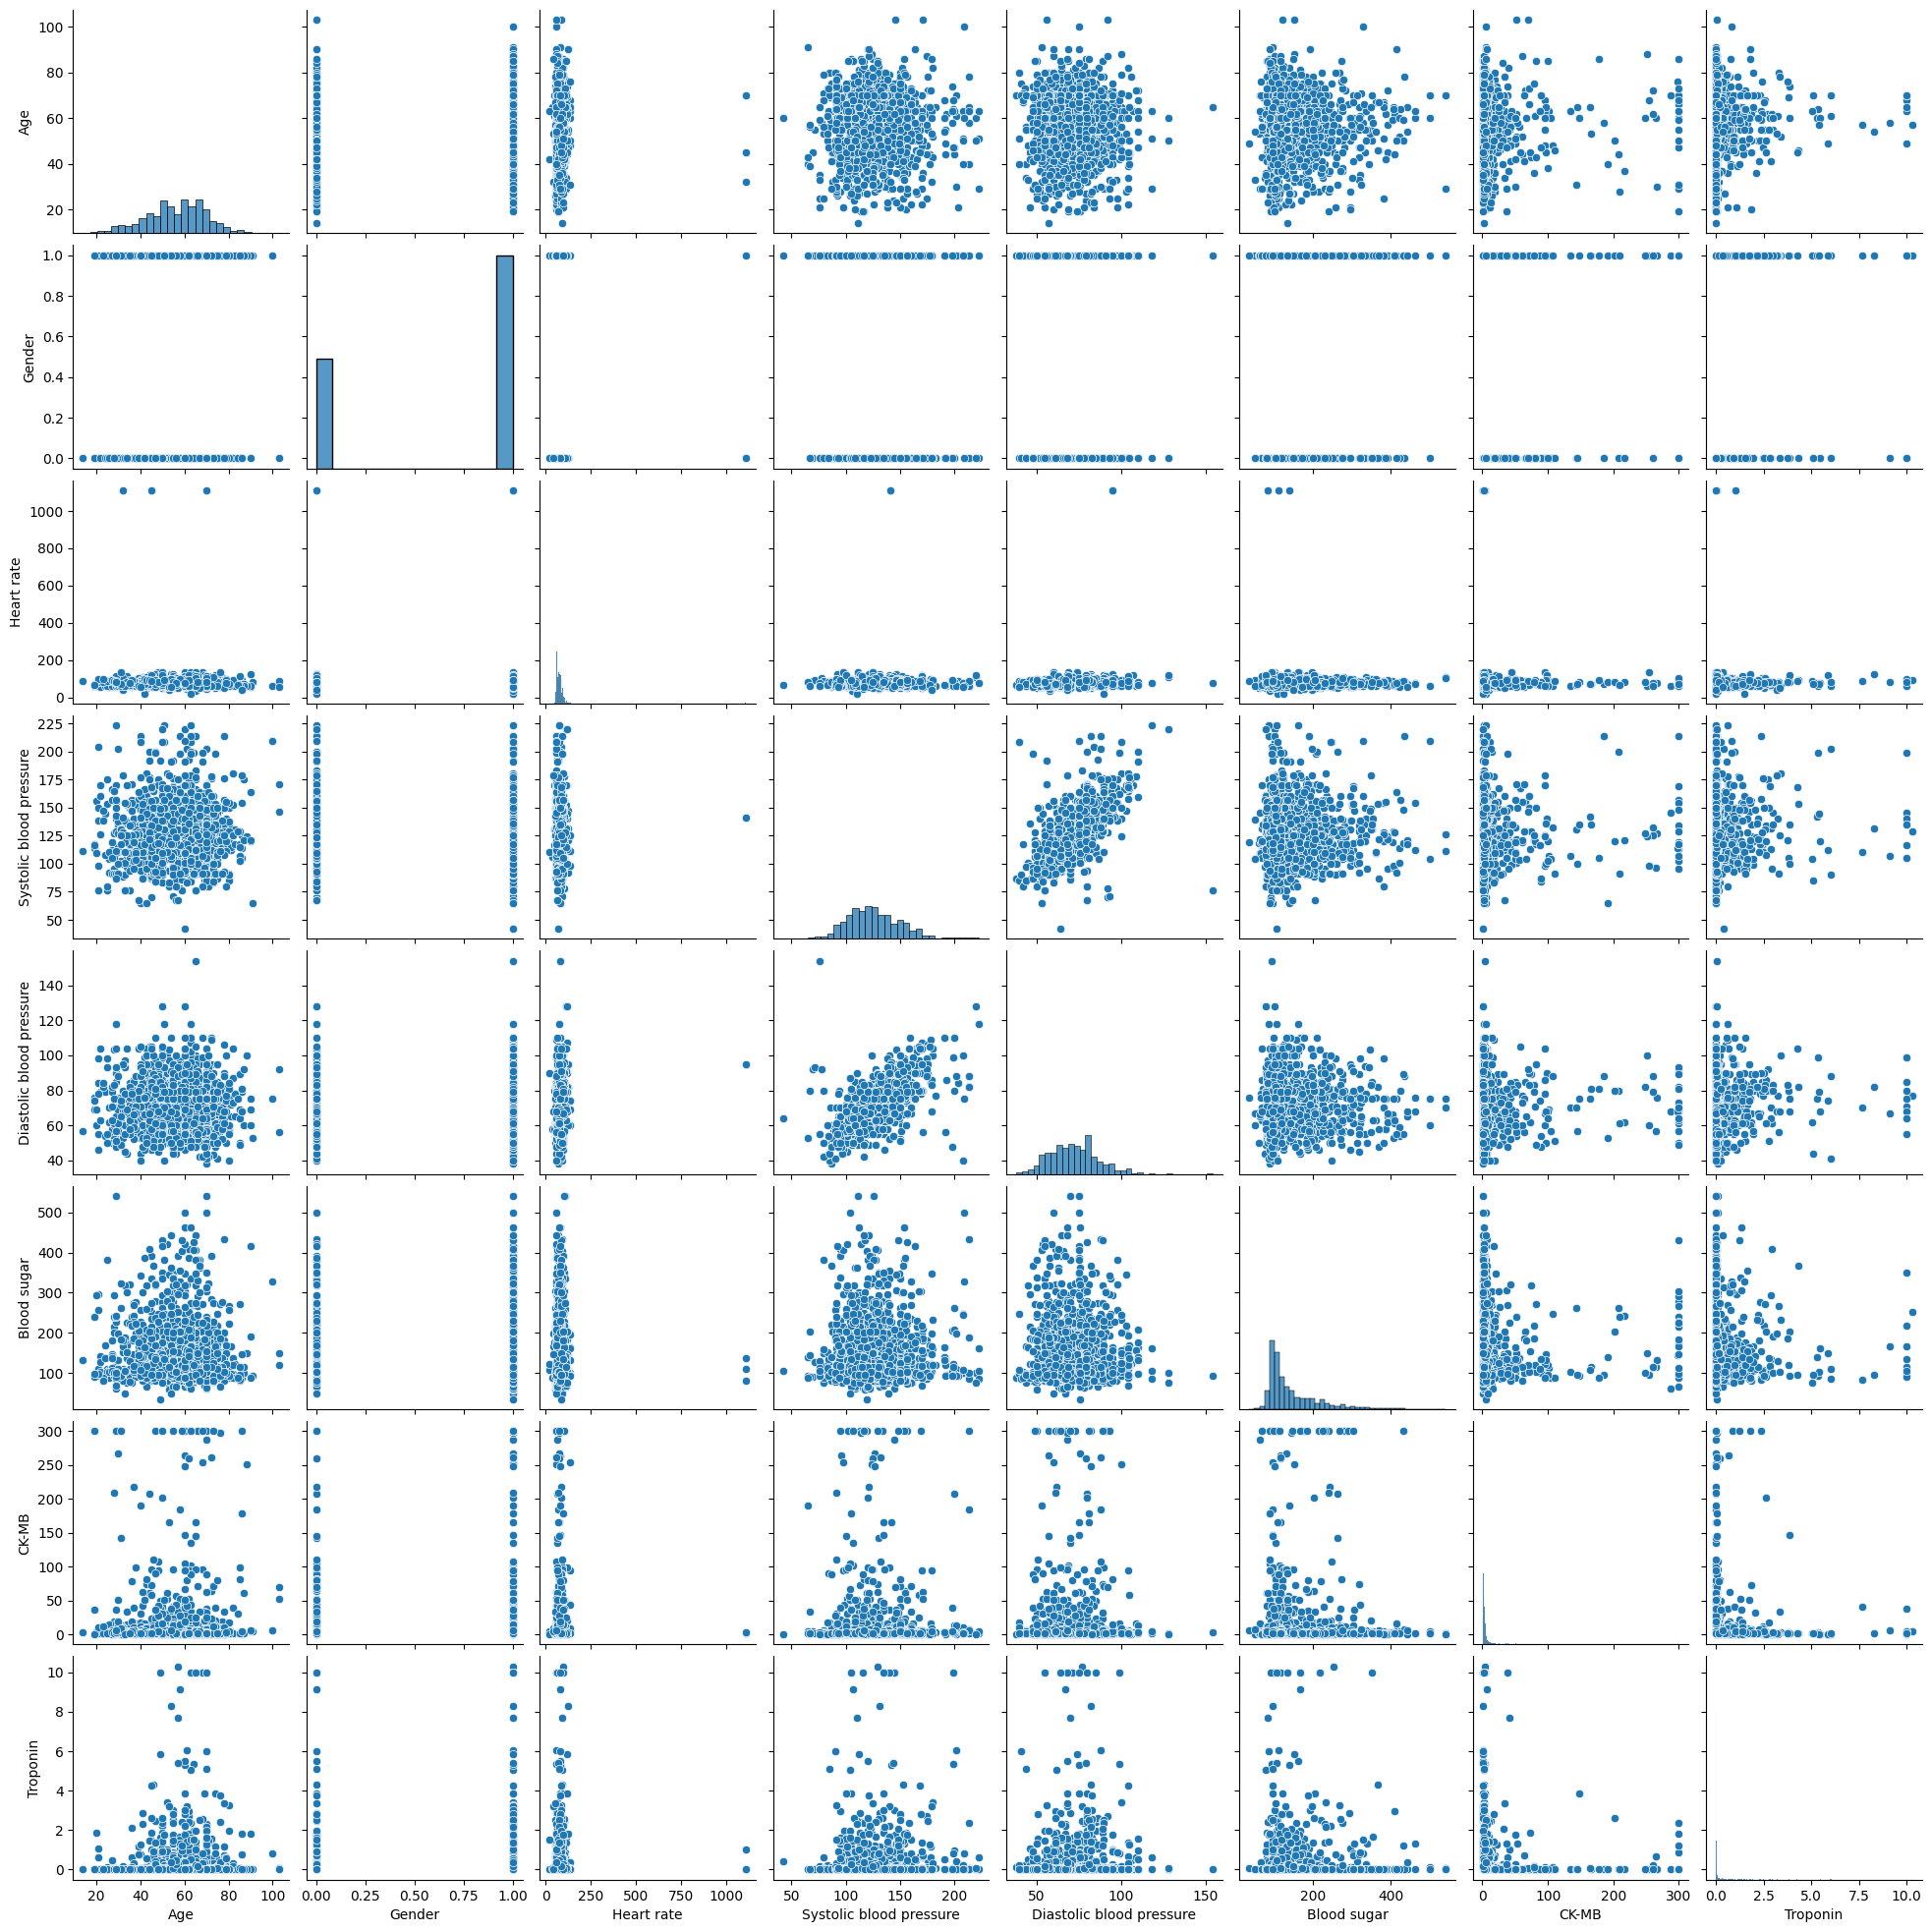

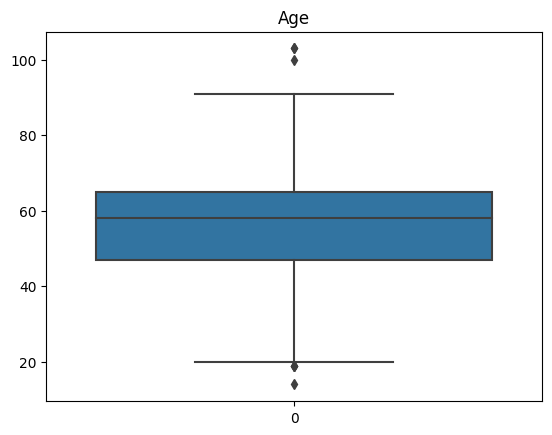

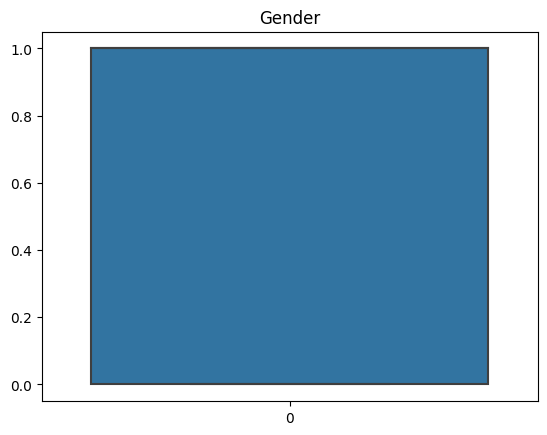

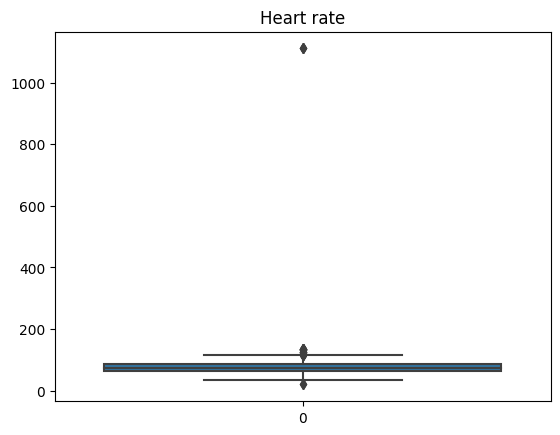

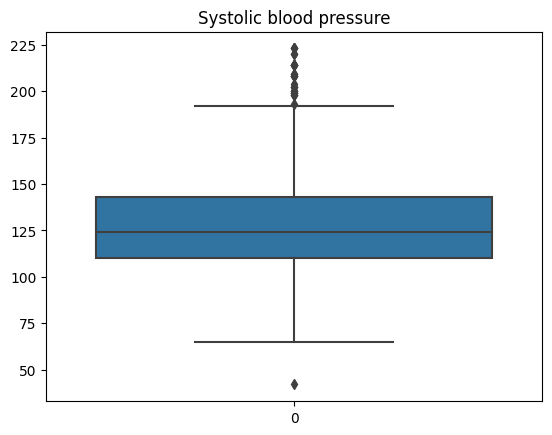

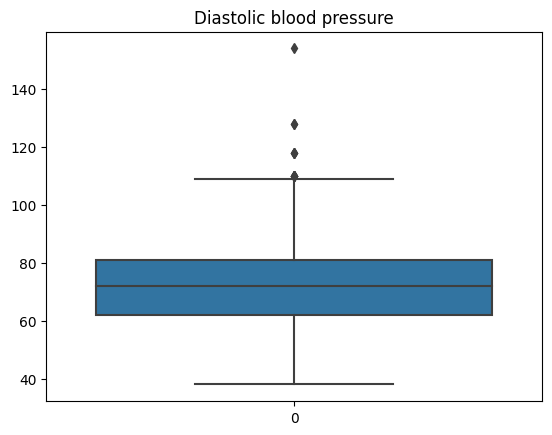

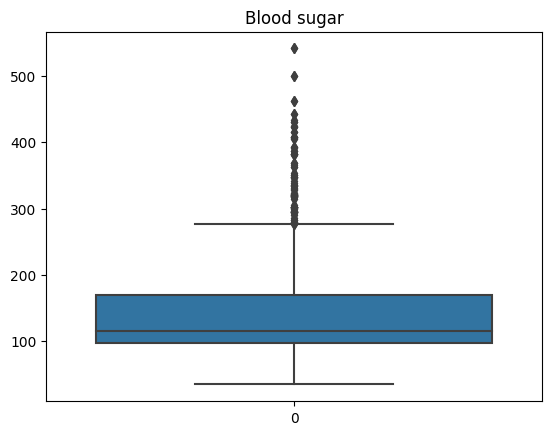

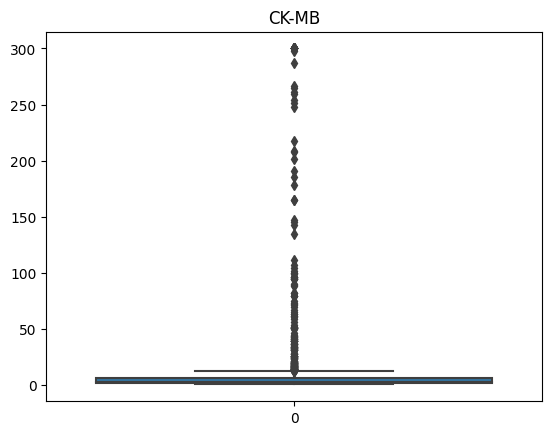

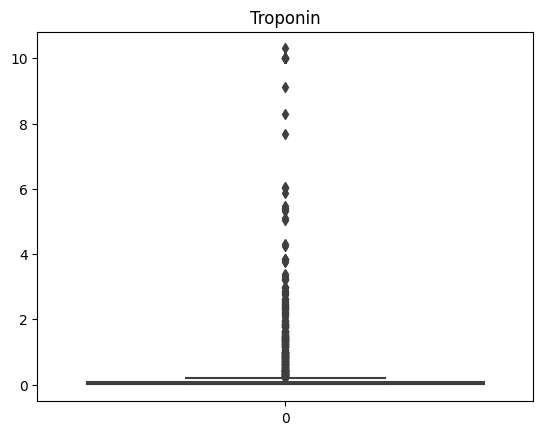

In [3]:
# Description
data=description("Medicaldataset.csv")
visualisation(data, data["Result"],"le titre")

# Prepocessing
data_clean = preprocess(data)

#encodage
# encodage des variables 
# variable target
label = preprocessing.LabelEncoder()
data_clean['Result'] = label.fit_transform(data_clean['Result'])

# variable binaire
binary = preprocessing.LabelBinarizer()
data_clean['Gender'] = binary.fit_transform(data_clean['Gender'])

# variables numeriques a faire apres le split ou pas

#Train test split
train_set, test_set = split(data_clean, 0.8, data_clean["Result"])
x_train, x_test, y_train, y_test = split_2(train_set, test_set)


### Preprocessing 2

In [4]:
x_data_2 = data.drop(columns = ['Systolic blood pressure','Result'])

In [5]:
x_data_2.head()

,Age,Gender,Heart rate,Diastolic blood pressure,Blood sugar,CK-MB,Troponin
0,64,1,66,83,160.0,1.80,0.012
1,21,1,94,46,296.0,6.75,1.060
2,55,1,64,77,270.0,1.99,0.003
3,64,1,70,55,270.0,13.87,0.122
4,55,1,64,65,300.0,1.08,0.003


Formule pour calculer la FCM (fréquence cardiaque maximale) :  
Homme : ```FCM = 220 - votre âge```  
Femme : ```FCM = 226 - votre âge```  
Source : <a href="https://www.decathloncoach.com/fr/home/advices/advice/frequence-cardiaque-reserve-repos-et-maximale">Décathlon coach</a>

Autre formule pour calculer sa FCM (fréquence cardiaque maximale) :  
```FCM = 207 – 0,7 x âge```  
Source : <a href="https://www.irbms.com/calculer-sa-frequence-cardiaque-pour-un-effort/">IRBMS</a>

In [6]:
#Calculer si les BPM sont possibles
x_data_2['BPM_possible'] = False
x_data_2.loc[data['Heart rate']<= 207 - (0.7*x_data_2['Age']), 'BPM_possible'] = True

In [7]:
x_data_2.loc[x_data_2['BPM_possible'] == False]

,Age,Gender,Heart rate,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,BPM_possible
63,45,1,1111,95,109.0,1.33,1.010,False
717,70,0,1111,95,138.0,3.87,0.028,False
1069,32,0,1111,95,82.0,2.66,0.008,False


In [8]:
data2 = x_data_2.loc[x_data_2['BPM_possible']==True]

# Do NOT execute bellow until models

In [ ]:
data = pd.read_csv("Medicaldataset.csv")
data.head()

In [ ]:
data.shape

In [ ]:
data.describe()

In [ ]:
data.isnull().sum()

In [ ]:
# inutile
round(data["Result"].value_counts(normalize=True),2)
# round(data["Troponin"].value_counts(),2)

In [ ]:
# test de visuel
data.dtypes.value_counts().plot.pie()

In [ ]:
plt.scatter(data["Diastolic blood pressure"],data["Age"])

In [ ]:
sns.scatterplot(data=data, x="Systolic blood pressure", y="Age", hue=data["Result"])
plt.title("Scatter plot of systolic pressure by age")

In [ ]:
sns.pairplot(data)

In [ ]:
# inutile
sns.heatmap(data.isna())

In [ ]:
for col in data.select_dtypes(['int','float']):
    plt.figure
    sns.displot(data[col])

In [ ]:
for col in data.select_dtypes(['int','float']):
    plt.figure
    sns.boxplot(data[col])
    plt.show()

# Preprocessing

In [ ]:
# nettoyage des outliers
data_clean = data.copy()
for col in data_clean.select_dtypes(['int','float']).columns:
    print(col)
    Q1 = data_clean[col].quantile(0.25)
    Q3 = data_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    # print(IQR, Q1-1.5*IQR, Q3+1.5*IQR)
    data_clean = data_clean[~((data_clean[col]<(Q1-1.5*IQR))|(data_clean[col]>(Q3+1.5*IQR)))]

In [ ]:
# visualisation de l'après nettoyage
for col in data_clean.select_dtypes(['int','float']):
    plt.figure
    sns.boxplot(data_clean[col])
    plt.show()

In [ ]:
data_clean.shape

In [ ]:
data_clean.head()

In [ ]:
# encodage des variables 
# variable target
label = preprocessing.LabelEncoder()
data_clean['Result'] = label.fit_transform(data_clean['Result'])

# variable binaire
binary = preprocessing.LabelBinarizer()
data_clean['Gender'] = binary.fit_transform(data_clean['Gender'])

# variables numeriques a faire apres le split ou pas

In [ ]:
data_clean.head()

# Application des modèles

In [ ]:
mdl_sup = [DecisionTreeClassifier(), RandomForestClassifier(),AdaBoostClassifier(), svm.SVC(),LinearSVC(),KNeighborsClassifier(),GaussianNB()]
#  "svm.SVC", "KNeighborsClassifier", "CategoricalNB","Adaboost"
# mdl_unsup = ["",""]

In [ ]:
def deco(x):
    print(str(x)*100)
def split(data,size,class_label):
    train_set, test_set = train_test_split(data, train_size=size, random_state=0, stratify=class_label)
    return train_set, test_set


def split_2(train_set, test_set):
    y_test = test_set["Result"]
    y_train = train_set["Result"]
    # encoder = preprocessing.LabelEncoder()
    # Y_encd = encoder.fit_transform(Y)
    x_train = train_set.iloc[:, 0:8]
    x_test = test_set.iloc[:, 0:8]
    return x_train, x_test, y_train, y_test

def implemantation_supervise(model, x_train, y_train, x_test, n_neighbors=3):
    #if model == KNeighborsClassifier:
        #MD = model(n_neighbors)
    #else:
    MD = model
    mdl = MD.fit(x_train, y_train)
    y_pred = mdl.predict(x_test)

    if model == DecisionTreeClassifier:
        plot_tree(MD,
                  feature_names=['Age', 'Gender', 'Heart rate', 'Systolic blood pressure','Diastolic blood pressure','Blood sugar','CK-MB','Troponin'],
                  class_names=["Positive", "Negative"], filled=True)
        plt.show()
    print("IMPLEMENTATION DE", MD)
    return y_pred


def scoring(y_pred, y_test):
    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    print("l'accuracy :\n", accuracy)
    deco("_")
    print("la matrice de confusion", confusion_matrix(y_test,y_pred))
    deco("_")
    print(classification_report(y_test, y_pred))
    deco("_")
    return(accuracy, f1, recall)
    
def implementation_unsupervised(model, x_train, n_clusters=3):
    MD = model(n_clusters)
    mdl = MD.fit(x_train)
    y_pred = mdl.predict(x_test)
    if model == KMeans:
        kmeans_clusters = MD.cluster_centers_
    print("IMPLEMENTATION DE", MD)
    return y_pred, kmeans_clusters


In [ ]:
train_set, test_set = split(data_clean, 0.8, data_clean['Result'])

print("la distribution des classes dans le train set :\n", round(train_set['Result'].value_counts(normalize=True),2))
deco("_")
print("la distribution des classes dans le test set :\n", round(test_set['Result'].value_counts(normalize=True),2))
visualisation(train_set, train_set["Result"], "Répartition des cas dans le train set")
deco("_")
visualisation(test_set, test_set["Result"], "Répartition des cas dans le test set")

In [ ]:
x_train, x_test, y_train, y_test = split_2(train_set, test_set)

In [ ]:
acc_sup = []
f1_sup = []
recall_sup = []

for m in mdl_sup:
    y_pred = implemantation_supervise(m, x_train, y_train, x_test)
    acc, f1,recall = scoring(y_pred, y_test)
    acc_sup.append(acc)
    f1_sup.append(f1)
    recall_sup.append(recall)
    

In [ ]:
plt.plot(score_sup)

In [ ]:
#Afficher la liste des scores dans une courbe
#print(score_list)
mdl_ls = ["DecisionTreeClassifier", "RandomForestClassifier","AdaBoostClassifier", "SVM","LinearSVC","KNeighborsClassifier","GaussianNB"]

fig, ax = plt.subplots()
ax.set(title="Les scores des différentes modélisations",
           ylabel="les scores",
          xlabel="les modèles")
ax.set_xticklabels(mdl_ls, rotation =45)
ax.plot(mdl_ls,acc_sup, label="accuracy")
ax.plot(mdl_ls,recall_sup, label="recall")
ax.plot(mdl_ls,f1_sup, label="f1 score")
plt.legend()